<h1>General State Space Model Data Simulation</h1>
Exog on state with AR Time Invariant Coefficients with intercept

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
%matplotlib inline



In [2]:
# Construct the model
class ss(sm.tsa.statespace.MLEModel):
    def __init__(self, endog,x_t):
        k_posdef = 2
        exog = x_t
        nobs = x_t.shape[0]
        # Initialize the state space model
        super(ss, self).__init__(endog, k_states=4, k_posdef=2,
                                  initialization='diffuse')
        
        '''
        xt = exog[np.newaxis, np.newaxis, :]
        zero = np.zeros([1,1,len(exog)])
        one = np.ones([1,1,len(exog)])
        con_design = np.concatenate((one,xt), axis = 1)
        '''

        # Setup the fixed components of the state space representation
        self.ssm['design'] = np.r_[1,0,0,0]
        self.ssm['transition'] = np.zeros([self.k_states, self.k_states, nobs])
        self.ssm['transition',0,2,:] = 1
        self.ssm['transition',0,1,:] = x_t
        self.ssm['transition',1,3,:] = 1
        self.ssm['selection'] = np.eye(self.k_states,k_posdef)
        
        self.positive_parameters = slice(0,3)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(ss, self).update(params, transformed, **kwargs)
        
        self.ssm['obs_cov', 0, 0] = params[0]
        self.ssm['state_cov', 0, 0] = params[1]
        self.ssm['state_cov', 1, 1] = params[2]
        #self.ssm['obs_intercept', 0, 0] = params[2]
        #self.ssm['state_intercept', 0, 0] = params[3]
        self.ssm['transition',0,0] = params[3]
        self.ssm['transition',2,0] = params[4]
        self.ssm['transition',1,1] = params[5]
        self.ssm['transition',3,1] = params[6]
        self.ssm['state_intercept', 0, :] = params[7]
        self.ssm['state_intercept', 1, :] = params[8]
        
    @property
    def param_names(self):
        return ['H','Q_alpha','Q_beta','phia1','phia2', 'phib1', 'phib2', 'c_alpha', 'c_beta']

    @property
    def start_params(self):
        #exog = sm.add_constant(x_t)
        #res = sm.OLS(self.endog, exog).fit()
        #params = np.r_[res.params[0], , 0.001, 0.001]
        return np.r_[[np.std(self.endog)]*3, 0.15, 0.15, 0.15, 0.15, 0.5, 0.5]
    
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

<li>General State Space Model<ol>
    <li>Z: Design</li>
    <li>d: Observation Intercept</li>
    <li>H: Observation Covariance </li>
    <li>T: Transition</li>
    <li>c: State Intercept</li>
    <li>R: Selection</li>
    <li>Q: State Covariance</li>
    </ol>
</li>
<br>
    
\begin{equation*}
y_{t} = Z_t\alpha_t + \epsilon_t \quad\epsilon_t \sim N(0,H_t)\\
\alpha_{t+1} = T_t\alpha_t + \beta_tx_t + c_t + R_t\eta_t \quad\eta_t \sim N(0,Q_t)
\end{equation*}

Example: full ss model with AR2 behavior
\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 & 0 & 0
\end{vmatrix}\alpha_t + \epsilon_t \quad\epsilon_t \sim N(0,H_t)\\
\alpha_{t+1} = \begin{vmatrix}
\phi_{\alpha,1} & 1 & x_t & 0\\
\phi_{\alpha,2} & 0 & 0 & 0\\
0 & 0 & \phi_{\beta,1} & 1\\
0 & 0 & \phi_{\beta,2} & 0\\
\end{vmatrix}\begin{vmatrix}
\alpha_t \\
\phi_{\alpha,2}\alpha_{t-1} \\
\beta_t \\
\phi_{\beta,2}\beta_{t-1}
\end{vmatrix} + \begin{vmatrix}
c_{\alpha}\\
0 \\
c_{\beta}\\
0
\end{vmatrix} + \begin{vmatrix}
\eta_t \\
0 \\
\omega_t \\
0
\end{vmatrix} \\
\quad\eta_t \sim N(0,Q_{\alpha,t})
\\
\quad\omega_t \sim N(0,Q_{\beta,t})
\end{equation*}


# True model parameters
nobs = int(1e4) \
H = 4 \
Q_alpha = 1 \
Q_beta = 0.64 \
phi_alpha = np.r_[0.5, -0.3, 0.2] \
phi_beta = np.r_[0.2, -0.8, 0.4] \
c_alpha = 3 \
c_beta = 2 


In [23]:
# True model parameters
nobs = int(1e4)
H = 4
Q = 1
d = 0
c = 3
ce = 2
phi = np.r_[0.5, -0.3]

beta_var = 0.64
beta_phi = np.r_[0.2, -0.8]


In [8]:
k = np.r_[6]
lambda1 = np.r_[3]
x_0 = 3
noise_var = 6

# Simulate a time series
np.random.seed(1211)

noise = np.random.normal(0, math.sqrt(noise_var), size=(nobs,))
u_t = x_0 + 1/lambda1 * noise
x_t = lfilter([1], np.r_[k/lambda1, 1], u_t)

In [21]:
x_t = np.ones(nobs)*3

In [24]:
period = 2000

cycle = [np.linspace(-np.pi, np.pi-np.pi/(period/2), period)] * int(nobs/period)
x_t_ang = np.reshape(np.array(cycle), nobs)
x_t = np.sin(x_t_ang)


In [35]:
np.random.seed(1211)
x_var = 3
x_phi = np.r_[0.2, -0.8]
x_t_ori = np.random.normal(0, math.sqrt(x_var), size=(nobs,))
x_t = lfilter([1], np.r_[1, -x_phi], x_t_ori)

In [25]:
# Simulate a time series
np.random.seed(1234)

beta_ind = np.random.normal(ce, math.sqrt(beta_var), size=(nobs,))
beta = lfilter([1], np.r_[1, -beta_phi], beta_ind)
state_int = x_t*beta
disturbances_eta = np.random.normal(c, math.sqrt(Q), size=(nobs,))
alpha = lfilter([1], np.r_[1, -phi], state_int+disturbances_eta)
disturbances_epsilon = np.random.normal(0, math.sqrt(H), size=(nobs,))
y_t = alpha + disturbances_epsilon + d


In [26]:
mod = ss(y_t,x_t)
res = mod.fit()
print(res.summary())

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                             ss   Log Likelihood              -23206.779
Date:                Tue, 07 Mar 2023   AIC                          46439.558
Time:                        08:52:09   BIC                          46533.292
Sample:                             0   HQIC                         46471.286
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H              4.0004      0.197     20.288      0.000       3.614       4.387
Q_alpha        0.9267      0.239      3.872      0.000       0.458       1.396
Q_beta         0.6010      0.103      5.824      0.0

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


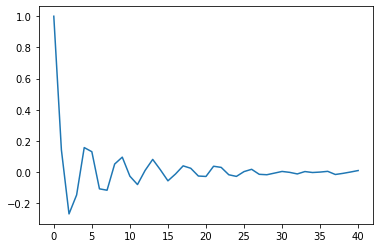

In [11]:
plt.plot(statsmodels.tsa.stattools.acf(y_t,fft=True))

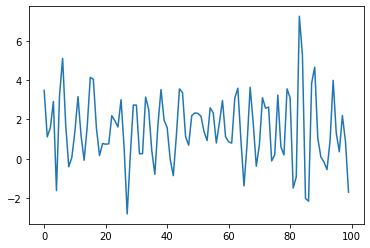

In [13]:
plt.plot(res.smoothed_state[0][:100])

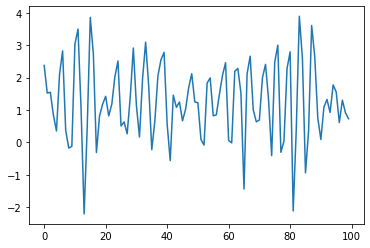

In [15]:
plt.plot(beta[:100])

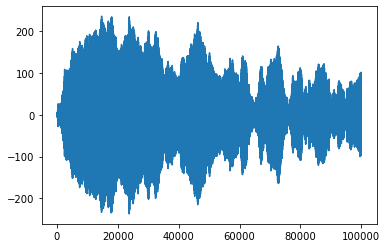

In [20]:
plt.plot(res.smoothed_state[1])

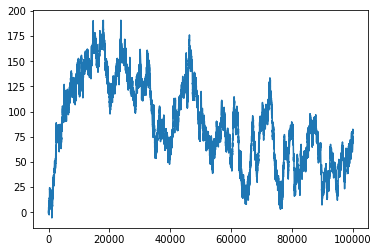

In [ ]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [91]:
mod = LocalLinearTrend(yt)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48342D+00    |proj g|=  5.67765D-04
  ys=-3.012E-01  -gs= 1.565E-01 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  6.21010D+00    |proj g|=  4.07811D-03

At iterate   10    f=  3.43768D+00    |proj g|=  3.09306D-01

At iterate   15    f=  3.13020D+00    |proj g|=  5.91948D-03

At iterate   20    f=  3.12672D+00    |proj g|=  1.39123D-03

At iterate   25    f=  3.12672D+00    |proj g|=  1.13442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     67      1     1     0   7.437D-07   3.127D+00
  F =   3.1267152983234783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                    